In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import pandas as pd
from tensorflow.keras.callbacks import Callback

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

import tensorflow.keras.applications

from pathlib import Path

import cv2

import math
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet121,DenseNet169,  \
                                          DenseNet201,InceptionResNetV2,  \
                                          InceptionV3,MobileNet,MobileNetV2,  \
                                          NASNetLarge,NASNetMobile,ResNet101,  \
                                          ResNet101V2,ResNet152,ResNet152V2,  \
                                          ResNet50,ResNet50V2,VGG16,VGG19,Xception  
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 8
IMG_HEIGHT = 512
IMG_WIDTH = 512
EPOCHS = 8
lr = 1e-3
CHANNELS =3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

FILTER_SIZE = 3

lrs = [('6e-4',6e-4), ('1e-3',1e-3), ('6e-3',6e-3)]
batch_sizes = [('8',8),('16',16)]
optimizers = [('Adam', tf.keras.optimizers.Adam()), 
              ('Nadam', tf.keras.optimizers.Nadam()), 
              ('SGD', tf.keras.optimizers.SGD()),
              ('RMSprop',tf.keras.optimizers.RMSprop())]

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [3]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [4]:
"""
Module for Image Save
"""


def save_grayscale(image, output_dir, output_name):
    """
    Save a 3D Numpy array (H, W, 1) as an image.
    Args:
        image (numpy.ndarray): Image to save
        output_dir (str): Output directory
        output_name (str): Output name
    """
    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)

    cv2.imwrite(str(Path(output_dir) / output_name), image)


def save_rgb(image, output_dir, output_name):
    """
    Save a 3D Numpy array (H, W, 3) as an image.
    Args:
        image (numpy.ndarray): Image to save
        output_dir (str): Output directory
        output_name (str): Output name
    """
    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)

    cv2.imwrite(
        str(Path(output_dir) / output_name), cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    )

In [5]:



def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(
                Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
                )
            )
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate(
        [
            np.concatenate(
                array[index * num_columns : (index + 1) * num_columns], axis=1
            )
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid


def filter_display(array, num_rows=None, num_columns=None):
    """
    Display a list of filter outputs as a greyscale images grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    return grid_display(
        np.concatenate(np.rollaxis(array, 3, 1), axis=0), num_rows, num_columns
    )


def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")


def heatmap_display(
    heatmap, original_image, colormap=cv2.COLORMAP_VIRIDIS, image_weight=0.7
):
    """
    Apply a heatmap (as an np.ndarray) on top of an original image.
    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply the heatmap
        colormap (int): OpenCV Colormap to use for heatmap visualization
        image_weight (float): An optional `float` value in range [0,1] indicating the weight of
            the input image to be overlaying the calculated attribution maps. Defaults to `0.7`
    Returns:
        np.ndarray: Original image with heatmap applied
    """
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    image = image_to_uint_255(original_image)

    heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())

    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap
    )

    output = cv2.addWeighted(
        cv2.cvtColor(image, cv2.COLOR_RGB2BGR), image_weight, heatmap, 1, 0
    )

    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [6]:
"""
Core Module for Grad CAM Algorithm
"""

class GradCAM:

    """
    Perform Grad CAM algorithm for a given input
    Paper: [Grad-CAM: Visual Explanations from Deep Networks
            via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
    """

    def explain(
        self,
        validation_data,
        model,
        class_index,
        layer_name=None,
        colormap=cv2.COLORMAP_VIRIDIS,
        image_weight=0.7,
    ):
        """
        Compute GradCAM for a specific class index.
        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            layer_name (str): Targeted layer for GradCAM. If no layer is provided, it is
                automatically infered from the model architecture.
            colormap (int): OpenCV Colormap to use for heatmap visualization
            image_weight (float): An optional `float` value in range [0,1] indicating the weight of
                the input image to be overlaying the calculated attribution maps. Defaults to `0.7`.
        Returns:
            numpy.ndarray: Grid of all the GradCAM
        """
        images, _ = validation_data

        if layer_name is None:
            layer_name = self.infer_grad_cam_target_layer(model)

        outputs, guided_grads = GradCAM.get_gradients_and_filters(
            model, images, layer_name, class_index
        )

        cams = GradCAM.generate_ponderated_output(outputs, guided_grads)

        heatmaps = np.array(
            [
                # not showing the actual image if image_weight=0
                heatmap_display(cam.numpy(), image, colormap, image_weight)
                for cam, image in zip(cams, images)
            ]
        )

        grid = grid_display(heatmaps)

        return grid

    @staticmethod
    def infer_grad_cam_target_layer(model):
        """
        Search for the last convolutional layer to perform Grad CAM, as stated
        in the original paper.
        Args:
            model (tf.keras.Model): tf.keras model to inspect
        Returns:
            str: Name of the target layer
        """
        for layer in reversed(model.layers):
            # Select closest 4D layer to the end of the network.
            if len(layer.output_shape) == 4:
                print(layer.name)
                return layer.name

        raise ValueError(
            "Model does not seem to contain 4D layer. Grad CAM cannot be applied."
        )

    @staticmethod
    @tf.function
    def get_gradients_and_filters(model, images, layer_name, class_index):
        """
        Generate guided gradients and convolutional outputs with an inference.
        Args:
            model (tf.keras.Model): tf.keras model to inspect
            images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
            layer_name (str): Targeted layer for GradCAM
            class_index (int): Index of targeted class
        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
        """
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_outputs)

        guided_grads = (
            tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
        )

        return conv_outputs, guided_grads

    @staticmethod
    def generate_ponderated_output(outputs, grads):
        """
        Apply Grad CAM algorithm scheme.
        Inputs are the convolutional outputs (shape WxHxN) and gradients (shape WxHxN).
        From there:
            - we compute the spatial average of the gradients
            - we build a ponderated sum of the convolutional outputs based on those averaged weights
        Args:
            output (tf.Tensor): Target layer outputs, with shape (batch_size, Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (batch_size, Hl, Wl, Nf)
        Returns:
            List[tf.Tensor]: List of ponderated output of shape (batch_size, Hl, Wl, 1)
        """

        maps = [
            GradCAM.ponderate_output(output, grad)
            for output, grad in zip(outputs, grads)
        ]

        return maps

    @staticmethod
    def ponderate_output(output, grad):
        """
        Perform the ponderation of filters output with respect to average of gradients values.
        Args:
            output (tf.Tensor): Target layer outputs, with shape (Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (Hl, Wl, Nf)
        Returns:
            tf.Tensor: Ponderated output of shape (Hl, Wl, 1)
        """
        weights = tf.reduce_mean(grad, axis=(0, 1))

        # Perform ponderated sum : w_i * output[:, :, i]
        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

        return cam

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.
        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_rgb(grid, output_dir, output_name)


In [7]:
train_df = pd.read_csv("./train.csv")
valid_df = pd.read_csv("./val.csv")

test_df = pd.read_csv("./test.csv")

train_df.head()

,image,fracture
0,2.25.106676839056126299978531324463554518020.png,0
1,2.25.319643122546098503457219076291109872435.png,0
2,2.25.274315312442912178046853147602337975791.png,1
3,2.25.220685474744735840984002265562904007370.png,1
4,2.25.155577563460858254065799391763762302742.png,1


In [8]:
labels = ['fracture']

In [9]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 512, target_h = 512):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=180,
        height_shift_range=[-10,10],
        width_shift_range=[-10,10],
        rescale=1./255)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [10]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=2000, batch_size=8, seed=1, target_w = 512, target_h = 512):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting test and valid generators...")
    

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
       rescale=1./255)
    
    

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [11]:
IMAGE_DIR = "/opt/AIStorage/PLAYGROUND/images/512/filtered/all_images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "image", labels)

getting train generator...
Found 7063 validated image filenames.
getting test and valid generators...
Found 882 validated image filenames.
Found 882 validated image filenames.


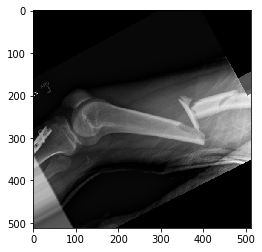

In [12]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

In [13]:
def create_model():
    base_model = DenseNet201(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
    
    #base_model.trainable = False
        
    for layer in base_model.layers:
        if layer.name.endswith('bn'):
            layer.trainable = True
        else:
            layer.trainable = False
                
    x = base_model.output
        
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(2, activation="sigmoid", dtype=tf.float32)(x)
        
    model = Model(inputs=base_model.input,outputs=predictions)
    
    return model
    

In [14]:
#val_image_count = 882
#image_count = 7063
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
STEPS_PER_EPOCH = len(train_generator) 
#VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = len(valid_generator) 

print("")
print("Arch: ", "DenseNet201")
    
#steps = np.ceil(image_count / BATCH_SIZE) * EPOCHS

#optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9, decay=1e-6, nesterov=True)
    
#optimizer = tf.keras.optimizers.RMSprop(lr=lr)
optimizer = tf.keras.optimizers.Adam(lr=lr)
    

model = create_model()

model.summary()
        
        
model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['acc'])
    
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=valid_generator, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[])
        
        
        
print("")
print("")



Arch:  DenseNet201
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 883 steps, validate for 111 steps
Epoch 1/8
883/883 [==============================] - 395s 448ms/step - loss: 0.5832 - acc: 0.7558 - val_loss: 0.3718 - val_acc: 0.8328
Epoch 2/8
883/883 [==============================] - 366s 415ms/step - loss: 0.3490 - acc: 0.8589 - val_loss: 0.3506 - val_acc: 0.8662
Epoch 3/8
883/883 [==============================] - 365s 414ms/step - loss: 0.3131 - acc: 0.8789 - val_loss: 0.2792 - val_acc: 0.8957
Epoch 4/8
883/883 [==============================] - 365s 414ms/step - loss: 0.2989 - acc: 0.8809 - val_loss: 0.3546 - val_acc: 0.8878
Epoch 5/8
883/883 [==============================] - 365s 414ms/step - loss: 0.2857 - acc: 0.8925 - val_loss: 0.2892 - val_acc: 0.8883
Epoch 6/8
883/883 [==============================] - 364s 412ms/step - loss: 0.2751 - acc: 0.8972 - val_loss: 0.2529 - val_acc: 0.9019
Epoch 7/8
883/883 [==============================] - 365s 413ms/step - loss: 0.2602 - acc: 0.903

In [15]:
#!mkdir -p saved_model

In [16]:
history.history

{'loss': [0.5832121324394878,
  0.3490722046751789,
  0.3130473251064624,
  0.2989406129918886,
  0.2857758984160621,
  0.275101288184724,
  0.26023495393397367,
  0.2576143458500372],
 'acc': [0.7557695,
  0.85891265,
  0.87887585,
  0.88092875,
  0.8925386,
  0.89721084,
  0.90301573,
  0.9023786],
 'val_loss': [0.3718155808411203,
  0.35064871652840496,
  0.2791854105470283,
  0.35462258308958094,
  0.2891948286544632,
  0.2528895932073529,
  0.46345034647766536,
  0.34051853312632524],
 'val_acc': [0.8327664,
  0.86621314,
  0.89569163,
  0.8877551,
  0.888322,
  0.9019274,
  0.82369614,
  0.8514739]}

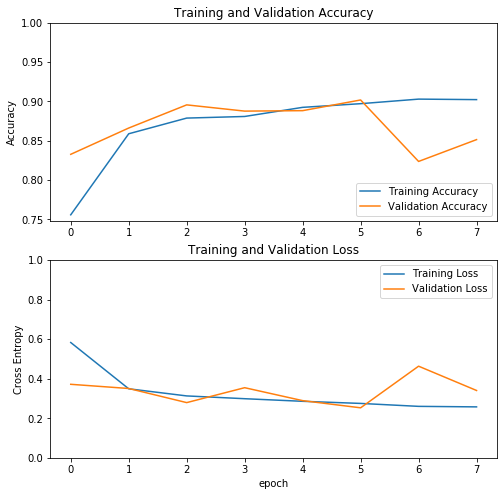

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
model.trainable = True

In [19]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    if layer.name.endswith('bn'):
        layer.trainable = True
    else:
        layer.trainable = False

Number of layers in the model:  714


In [20]:
#optimizer = tf.keras.optimizers.SGD(lr=lr/10, momentum=0.9, decay=1e-6, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=lr/10)
model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['acc'])
    

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [22]:
fine_tune_epochs = 8
total_epochs =  EPOCHS + fine_tune_epochs


In [23]:
history_fine = model.fit(train_generator,
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1],
                    validation_data=valid_generator, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 883 steps, validate for 111 steps
Epoch 8/16
883/883 [==============================] - 393s 445ms/step - loss: 0.2293 - acc: 0.9141 - val_loss: 0.2341 - val_acc: 0.9087
Epoch 9/16
883/883 [==============================] - 363s 411ms/step - loss: 0.2019 - acc: 0.9267 - val_loss: 0.2155 - val_acc: 0.9257
Epoch 10/16
883/883 [==============================] - 365s 413ms/step - loss: 0.1844 - acc: 0.9313 - val_loss: 0.2498 - val_acc: 0.9229
Epoch 11/16
883/883 [==============================] - 365s 413ms/step - loss: 0.1823 - acc: 0.9302 - val_loss: 0.2122 - val_acc: 0.9201
Epoch 12/16
883/883 [==============================] - 365s 413ms/step - loss: 0.1718 - acc: 0.9399 - val_loss: 0.2280 - val_acc: 0.9240
Epoch 13/16
883/883 [==============================] - 364s 413ms/step - loss: 0.1618 - acc: 0.9434 - val_loss: 0.2174 - val_acc: 0.9252
Epoch 14/16
883/883 [==============================] - 366s 414ms/step - loss: 0.1596 

In [24]:

acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

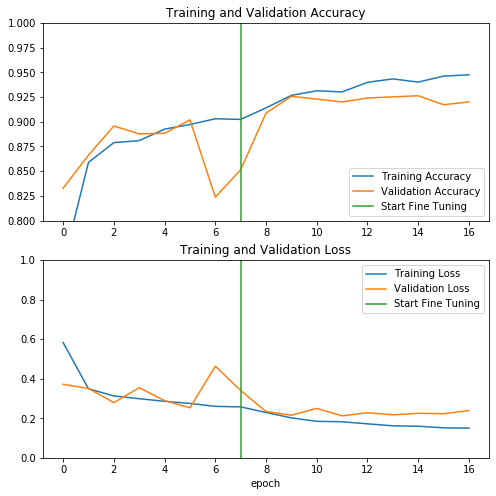

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
model.trainable = True

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

Total params: 7,903,618
Trainable params: 7,669,698
Non-trainable params: 233,920
__________________________________________________________________________________________________


In [28]:
#optimizer = tf.keras.optimizers.SGD(lr=lr/60, momentum=0.9, decay=1e-6, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=lr/60)
model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['acc'])
    

In [29]:
unfreeze_epochs = 8
total_epochs =  EPOCHS + fine_tune_epochs + unfreeze_epochs

In [ ]:
history_unfreeze = model.fit(train_generator,
                    epochs=total_epochs,
                    initial_epoch =  history_fine.epoch[-1],
                    validation_data=valid_generator, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 883 steps, validate for 111 steps
Epoch 16/24
882/883 [============================>.] - ETA: 0s - loss: 0.1607 - acc: 0.9386

In [ ]:
acc += history_unfreeze.history['acc']
val_acc += history_unfreeze.history['val_acc']

loss += history_unfreeze.history['loss']
val_loss += history_unfreeze.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([(EPOCHS+fine_tune_epochs)-1,(EPOCHS+fine_tune_epochs)-1],
          plt.ylim(), label='Start Full Unfreeze')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([(EPOCHS+fine_tune_epochs)-1,(EPOCHS+fine_tune_epochs)-1],
          plt.ylim(), label='Start Full Unfreeze')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.save_weights('saved_model/my_model_weights')

In [ ]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_policy(policy)

In [ ]:
saved_model = create_model()

In [ ]:
saved_model.load_weights('saved_model/my_model_weights')

In [ ]:
x, y = valid_generator.__getitem__(0)

In [ ]:
plt.imshow(x[0]);

In [ ]:
x[0].shape

In [ ]:
#IMAGE_PATH = '/opt/AIStorage/PLAYGROUND/images/512/filtered/data_filtered/train/data_filtered/positive/2.25.29063837649503765322829207716135903912.png'
#IMAGE_PATH = '/opt/AIStorage/PLAYGROUND/images/512/positive/2.25.293051404113555009465480448588513430295.png'
IMAGE_PATH = '/opt/AIStorage/PLAYGROUND/images/512/positive/2.25.181219916381488720424316063428743387152.png'
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(512, 512))
img = tf.keras.preprocessing.image.img_to_array(img)

img = img/255.0


data = ([x[0]], None)

index = 0
explainer = GradCAM()
        
saved_model.trainable = True
        
#layer ='conv2_block1_1_conv'
layer ='conv5_block32_2_conv'
    
grid = explainer.explain(data, saved_model, class_index=index, image_weight=0.5, layer_name=layer)
    
explainer.save(grid, ".", "grad_cam10_16__2x0_5_adam.png")